# I. Data Exploration

Load the file 'customer_segmentation.csv' into a dataset named 'df'

In [87]:
import pandas as pd
from IPython.display import display

df = pd.read_csv('customer_segmentation.csv')
display(df.head().style.hide(axis="index"))

Customer ID,Age,Annual Income (K$),Gender,Product Category Purchased,Average Spend per Visit ($),Number of Visits in Last 6 Months,Customer Segment
1,56,106,Female,Fashion,163.452764,16,Premium Shopper
2,69,66,Female,Home,163.020496,31,Budget Shopper
3,46,110,Male,Fashion,104.541284,29,Budget Shopper
4,32,50,Male,Electronics,110.064567,26,Regular Shopper
5,60,73,Female,Others,142.254559,38,Regular Shopper


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10532 entries, 0 to 10531
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        10532 non-null  int64  
 1   Age                                10532 non-null  int64  
 2   Annual Income (K$)                 10532 non-null  int64  
 3   Gender                             10532 non-null  object 
 4   Product Category Purchased         10532 non-null  object 
 5   Average Spend per Visit ($)        10532 non-null  float64
 6   Number of Visits in Last 6 Months  10532 non-null  int64  
 7   Customer Segment                   10532 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 658.4+ KB


There are 10532 rows in the dataset and 8 variables, 5 of which are numerical and the remaining 3 are of object type.

In [89]:
df.isnull().sum()

Customer ID                          0
Age                                  0
Annual Income (K$)                   0
Gender                               0
Product Category Purchased           0
Average Spend per Visit ($)          0
Number of Visits in Last 6 Months    0
Customer Segment                     0
dtype: int64

In [90]:
df.groupby('Age').size().get('0', 0)

0

There are no missing entries in the dataset. Moreover, there are no invalid (age 0) entries for the 'Age' column, hence the dataset is legitimate.

### Age Distribution

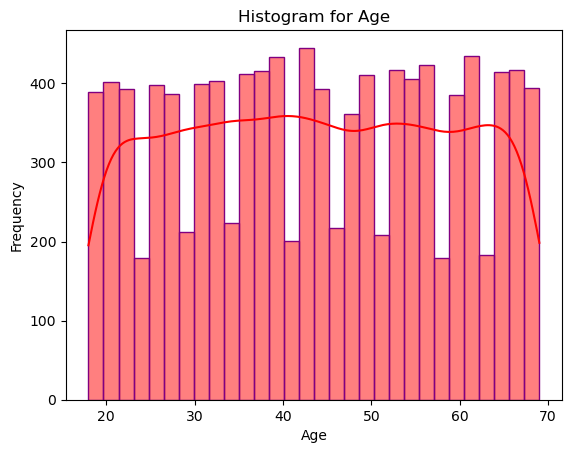

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['Age'], bins=30, kde=True, color='red', edgecolor='purple')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram for Age')
plt.show()

There seems to be no trend in the distribution of ages in the dataset, hence the plateaued density line.

### Annual Income Distribution

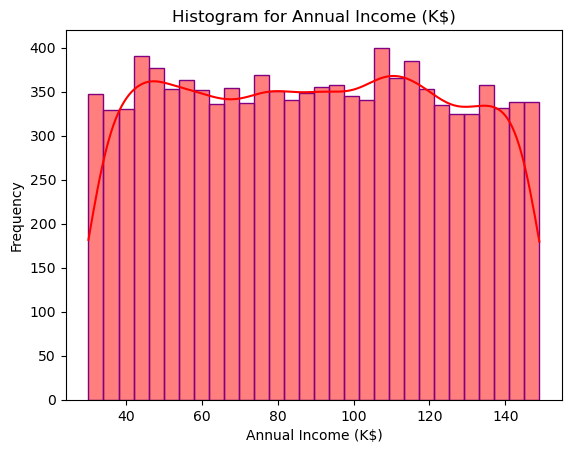

In [92]:
sns.histplot(df['Annual Income (K$)'], bins=30, kde=True, color='red', edgecolor='purple')
plt.xlabel('Annual Income (K$)')
plt.ylabel('Frequency')
plt.title('Histogram for Annual Income (K$)')
plt.show()

### Average Spend per Visit Distribution

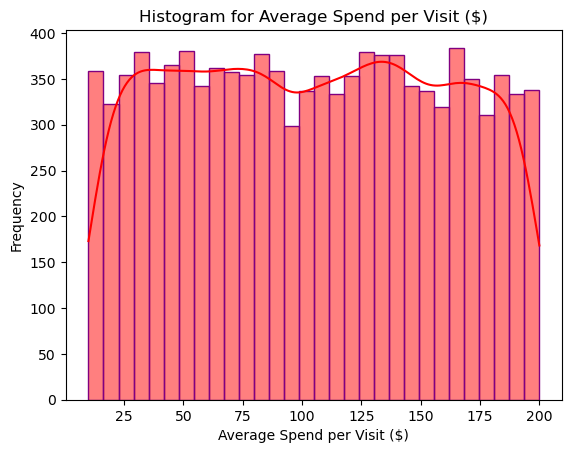

In [93]:
sns.histplot(df['Average Spend per Visit ($)'], bins=30, kde=True, color='red', edgecolor='purple')
plt.xlabel('Average Spend per Visit ($)')
plt.ylabel('Frequency')
plt.title('Histogram for Average Spend per Visit ($)')
plt.show()

### Customer Segment Distribution

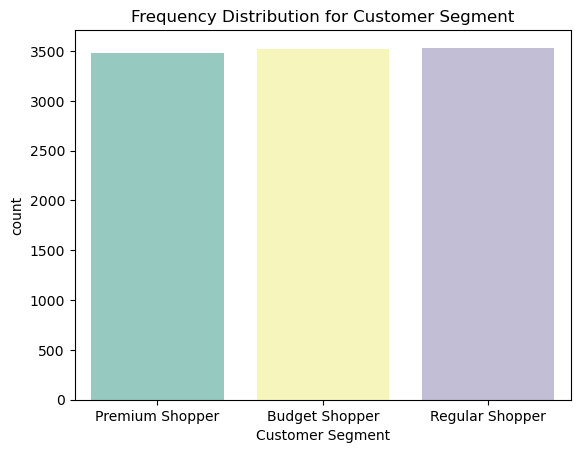

In [94]:
sns.countplot(x='Customer Segment', data=df, hue='Customer Segment', palette='Set3')
plt.title("Frequency Distribution for Customer Segment")
plt.show()

As observed from the frequency distribution, the counts for all three customer segments are almost equal. This is a good sign since it could potentially allow the model to have less bias in formulating the variable coefficients.

# II. Data Preprocessing

### One-Hot Encoding for the product category

The 'Product Category Purchased' column will be one-hot encoded to make it for the model creation process.

In [95]:
df_copy = df.copy()
df_copy = pd.get_dummies(df_copy, columns=['Product Category Purchased'], dtype=int)
display(df_copy.head().style.hide(axis="index"))

Customer ID,Age,Annual Income (K$),Gender,Average Spend per Visit ($),Number of Visits in Last 6 Months,Customer Segment,Product Category Purchased_Books,Product Category Purchased_Electronics,Product Category Purchased_Fashion,Product Category Purchased_Home,Product Category Purchased_Others
1,56,106,Female,163.452764,16,Premium Shopper,0,0,1,0,0
2,69,66,Female,163.020496,31,Budget Shopper,0,0,0,1,0
3,46,110,Male,104.541284,29,Budget Shopper,0,0,1,0,0
4,32,50,Male,110.064567,26,Regular Shopper,0,1,0,0,0
5,60,73,Female,142.254559,38,Regular Shopper,0,0,0,0,1


### Label Encoding for the gender category

Since we need the model to recognize the categorical 'Gender' variable, then it should be replaced with a numerical form through label encoding.

In [96]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
df_copy['Gender']= label_encoder.fit_transform(df_copy['Gender'])
display(df_copy.head().style.hide(axis="index"))

Customer ID,Age,Annual Income (K$),Gender,Average Spend per Visit ($),Number of Visits in Last 6 Months,Customer Segment,Product Category Purchased_Books,Product Category Purchased_Electronics,Product Category Purchased_Fashion,Product Category Purchased_Home,Product Category Purchased_Others
1,56,106,0,163.452764,16,Premium Shopper,0,0,1,0,0
2,69,66,0,163.020496,31,Budget Shopper,0,0,0,1,0
3,46,110,1,104.541284,29,Budget Shopper,0,0,1,0,0
4,32,50,1,110.064567,26,Regular Shopper,0,1,0,0,0
5,60,73,0,142.254559,38,Regular Shopper,0,0,0,0,1


### Scaling Continuous Variables - Age, Annual Income, and Average Spend per Visit

From the previous histograms, all three variables 'Age', 'Annual Income (K$\$$)', and 'Average Spend per Visit (\$)' have flat distributions. We need to scale these data to ensure better results from the model.

In [97]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_copy['Age'] = scaler.fit_transform(pd.DataFrame(df_copy['Age']))
df_copy['Annual Income (K$)'] = scaler.fit_transform(pd.DataFrame(df_copy['Annual Income (K$)']))
df_copy['Average Spend per Visit ($)'] = scaler.fit_transform(pd.DataFrame(df_copy['Average Spend per Visit ($)']))
display(df_copy.head().style.hide(axis="index"))

Customer ID,Age,Annual Income (K$),Gender,Average Spend per Visit ($),Number of Visits in Last 6 Months,Customer Segment,Product Category Purchased_Books,Product Category Purchased_Electronics,Product Category Purchased_Fashion,Product Category Purchased_Home,Product Category Purchased_Others
1,0.832437,0.488716,0,1.083269,16,Premium Shopper,0,0,1,0,0
2,1.704710,-0.673767,0,1.075353,31,Budget Shopper,0,0,0,1,0
3,0.161457,0.604964,1,0.004478,29,Budget Shopper,0,0,1,0,0
4,-0.777915,-1.138760,1,0.105621,26,Regular Shopper,0,1,0,0,0
5,1.100829,-0.470332,0,0.695086,38,Regular Shopper,0,0,0,0,1


### 80-20 Train-Test Split

As the final preparation for model fitting, the dataset must be split by a proportion of 80-20 corresponding to train-test sets.

In [99]:
from sklearn.model_selection import train_test_split

x = df_copy.drop('Customer Segment', axis=1)
y = df_copy['Customer Segment']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)

# III. Model Building

### Initial Multinomial Regression Model Training

In [100]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', max_iter=5000) # multi_class has already been deprecated in v1.5
model.fit(x_train, y_train)

LogisticRegression(max_iter=5000)

### Tuning Hyperparameters

We want to use the best regularization strength (C) for this model. Once obtained, we can retrain the model using that value.

In [101]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(x_train, y_train)

print(f"Best C value: {grid_search.best_params_['C']}")

Best C value: 0.01


The model will be retrained using the optimal C value of 0.01.

In [102]:
model = LogisticRegression(solver='lbfgs', max_iter=5000, C=0.01)
model.fit(x_train, y_train)

LogisticRegression(C=0.01, max_iter=5000)

# IV. Model Evaluation

### Accuracy

In [103]:
model.score(x_test, y_test)

0.32842904603701945

The accuracy score for the model is **32.84%**.

### Log-Loss

In [104]:
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

y_predicted_proba = model.predict_proba(x_test)
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

print(log_loss(y_test_encoded, y_predicted_proba))

1.101609032554527


A log-loss of around **1.10161** means that the model only provides a $e^{-1.10161}\approx33.23\%$ probability estimate for the actual class. This implies that the model's confidence in predicting the correct class is fairly low.

### Precision, Recall, F1-score

In [105]:
from sklearn.metrics import classification_report

y_predicted = model.predict(x_test)
print(classification_report(y_test, y_predicted))

                 precision    recall  f1-score   support

 Budget Shopper       0.32      0.37      0.35       703
Premium Shopper       0.32      0.19      0.24       697
Regular Shopper       0.34      0.42      0.37       707

       accuracy                           0.33      2107
      macro avg       0.33      0.33      0.32      2107
   weighted avg       0.33      0.33      0.32      2107



### Confusion Matrix

Based on the given scores, it can be inferred that the model's predictive power is fairly low across the board, even being very low on the 'Premium Shopper' customer segment. The precision, recall, and f1-scores only range around the 0.3 mark, coinciding with the low accuracy of 32.84% from earlier.

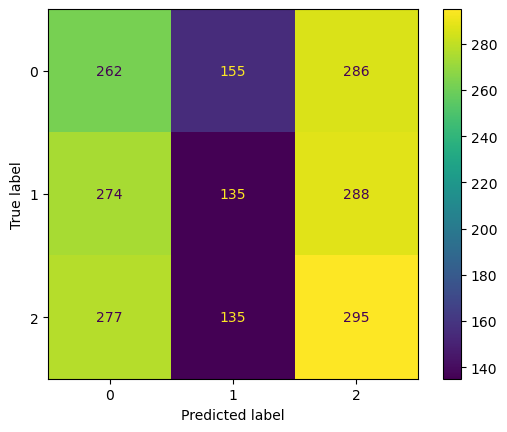

In [106]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_display.plot()
plt.show()

Based on the model's confusion matrix, it has a **high rate of misclassification**, especially on the 'Premium Shopper' and 'Regular Shopper' customer segments. In particular, many 'Budget Shopper' entries were misclassified as 'Regular Shopper' and vice versa, though note that this is to be expected since the gap between the two segments is quite small. These findings line up with both the low metrics given previously especially with the precision, recall, and f1-score table. That being said, the model can still effectively differentiate between 'Budget Shopper' entries and those of 'Premium Shopper' types, which could be a commendable point.

### Initial Model Coefficients

In [107]:
response_variables = ['Budget Shopper', 'Premium Shopper', 'Regular Shopper']
coef_df = pd.DataFrame(model.coef_, columns=x.columns, index=response_variables)

coef_df

,Customer ID,Age,Annual Income (K$),Gender,Average Spend per Visit ($),Number of Visits in Last 6 Months,Product Category Purchased_Books,Product Category Purchased_Electronics,Product Category Purchased_Fashion,Product Category Purchased_Home,Product Category Purchased_Others
Budget Shopper,4.247413e-06,-0.014828,0.017747,0.027823,0.012785,0.001233,0.086638,-0.009194,-0.072880,0.029296,-0.035604
Premium Shopper,-5.717169e-07,-0.010900,-0.004621,0.010877,-0.010890,-0.001042,-0.033532,-0.003283,0.059244,-0.010399,-0.011638
Regular Shopper,-3.675696e-06,0.025728,-0.013126,-0.038699,-0.001895,-0.000191,-0.053106,0.012476,0.013636,-0.018897,0.047242


All coefficients are low, implying low influence for each predictor in affecting the response variable. Out of all predictors, the purchase of books seems to be the most influential for 'Budget Shopper,' purchase of fashion for 'Premium Shopper,' and the purchase of other categories for 'Regular Shopper.' This could imply that budget shoppers tend to purchase books, premium shoppers purchase fashion items, and regular shoppers buy products of other categories, however the correlations are still very low.

# V. Refinement

### Model Improvements

Customer ID has shown to be inconsequential to determining the customer segment, hence it must be removed since it is only considered as noise. Additionally, we could try combining the 'Age' and 'Annual Income' columns together to create a new interaction variable called 'Age + Annual Income' for the new model. Addition will be done since they are both on a similar scale. Furthermore, new columns for age-spending ratio and income-visits product will be added then standard-scaled for more interaction effects.

In [514]:
df_copy1 = df_copy.copy()
df_copy1['Age_Income_Sum'] = df_copy1['Age'] + df_copy1['Annual Income (K$)']
df_copy1['Age_Spend_Ratio'] = df_copy1['Age'] / (df_copy1['Average Spend per Visit ($)'])
df_copy1['Income_Visits_Product'] = df_copy1['Annual Income (K$)'] * df_copy1['Number of Visits in Last 6 Months']
df_copy1[['Income_Visits_Product']] = scaler.fit_transform(df_copy1[['Income_Visits_Product']])
df_copy1[['Age_Spend_Ratio']] = scaler.fit_transform(df_copy1[['Age_Spend_Ratio']])
df_copy1.drop(['Customer ID'], axis=1, inplace=True)

In [515]:
display(df_copy1.head().style.hide(axis="index"))

Age,Annual Income (K$),Gender,Average Spend per Visit ($),Number of Visits in Last 6 Months,Customer Segment,Product Category Purchased_Books,Product Category Purchased_Electronics,Product Category Purchased_Fashion,Product Category Purchased_Home,Product Category Purchased_Others,Age_Income_Sum,Age_Spend_Ratio,Income_Visits_Product
0.832437,0.488716,0,1.083269,16,Premium Shopper,0,0,1,0,0,1.321152,0.002925,0.333887
1.704710,-0.673767,0,1.075353,31,Budget Shopper,0,0,0,1,0,1.030944,0.013384,-0.854708
0.161457,0.604964,1,0.004478,29,Budget Shopper,0,0,1,0,0,0.766421,0.454747,0.736535
-0.777915,-1.138760,1,0.105621,26,Regular Shopper,0,1,0,0,0,-1.916674,-0.101217,-1.215805
1.100829,-0.470332,0,0.695086,38,Regular Shopper,0,0,0,0,1,0.630496,0.013364,-0.729906


We can now proceed to training a new model using the previous steps.

### 80-20 Training-Test Split

In [516]:
x = df_copy1.drop('Customer Segment', axis=1)
y = df_copy1['Customer Segment']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)

### Initial Multinomial Regression Model Training

In [517]:
model = LogisticRegression(solver='lbfgs', max_iter=5000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=5000)

### Tuning Hyperparameters

In [518]:
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(x_train, y_train)

print(f"Best C value: {grid_search.best_params_['C']}")

Best C value: 0.01


### Model Training with Best C

In [519]:
model = LogisticRegression(solver='lbfgs', max_iter=5000, C=0.01)
model.fit(x_train, y_train)

LogisticRegression(C=0.01, max_iter=5000)

### Accuracy

In [520]:
model.score(x_test, y_test)

0.31846226862838156

### Log-Loss

In [521]:
y_predicted_proba = model.predict_proba(x_test)
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

print(log_loss(y_test_encoded, y_predicted_proba))

1.1017746480159127


### Prediction, Recall, F1-score

In [522]:
y_predicted = model.predict(x_test)
print(classification_report(y_test, y_predicted))

                 precision    recall  f1-score   support

 Budget Shopper       0.31      0.35      0.33       703
Premium Shopper       0.31      0.20      0.25       697
Regular Shopper       0.33      0.40      0.36       707

       accuracy                           0.32      2107
      macro avg       0.32      0.32      0.31      2107
   weighted avg       0.32      0.32      0.31      2107



### Confusion Matrix

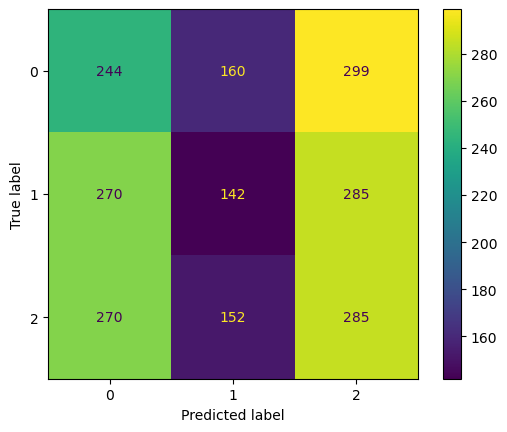

In [523]:
confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_display.plot()
plt.show()

### Refined Model Coefficients

In [524]:
response_variables = ['Budget Shopper', 'Premium Shopper', 'Regular Shopper']
coef_df = pd.DataFrame(model.coef_, columns=x.columns, index=response_variables)

coef_df

,Age,Annual Income (K$),Gender,Average Spend per Visit ($),Number of Visits in Last 6 Months,Product Category Purchased_Books,Product Category Purchased_Electronics,Product Category Purchased_Fashion,Product Category Purchased_Home,Product Category Purchased_Others,Age_Income_Sum,Age_Spend_Ratio,Income_Visits_Product
Budget Shopper,-0.008432,0.001934,0.027517,0.012909,0.001196,0.081834,-0.013296,-0.075832,0.024865,-0.039979,-0.006497,0.017176,0.025108
Premium Shopper,-0.015453,0.020105,0.011034,-0.010902,-0.001053,-0.032212,-0.002208,0.059784,-0.009041,-0.010294,0.004652,0.012770,-0.033424
Regular Shopper,0.023885,-0.022040,-0.038551,-0.002007,-0.000143,-0.049622,0.015504,0.016048,-0.015824,0.050274,0.001845,-0.029946,0.008316


### Cross-Validation

In [525]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, x, y, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-Validation Accuracy Scores: [0.32890365 0.33602278 0.34710351 0.32288699 0.3357075 ]
Mean CV Accuracy: 0.33412488827771225


The accuracy scores are fairly consistent across the folds, but the mean accuracy is still far from optimal. Hence, the model has low performance in generalization. Overall, the more complex new model performs similarly but is still slightly worse than the first one. However, note that it performs slightly better in predicting 'Premium Shopper' typings than the previous model.

# VI. Reporting

The customer segmentation model was developed using multinomial logistic regression. The dataset underwent careful preprocessing, including standardization of key numerical features like Age and Annual Income to ensure consistency in scale. Interaction features were introduced to capture potential relationships between variables, such as the product of income and visit frequency, aiming to improve prediction accuracy. To optimize performance, hyperparameter tuning was conducted to allow the model to find the best regularization strength (C) for improved classification. Once trained, the model’s generalization ability was assessed through a five-fold cross-validation process, ensuring its stability and effectiveness in predicting different customer segments. Two models were trained, one being more complex than the other, but the simpler of the two performed ever so slightly better in comparison.

Coefficients revealed that variables such as the various product categories, Income_Visits_Product, Annual Income, and suprisingly Gender, played a significant role in distinguishing different customer profiles. These features influence whether a shopper falls into the Budget, Premium, or Regular category, highlighting patterns in spending behavior and engagement levels. Regarding the Gender coefficient, Budget and Premium Shoppers was very slightly influenced by being a Male customer while Regular Shoppers were frequently Female. While interaction features were tested, some introduced complexity without significantly enhancing predictive power, suggesting that simpler transformations might yield more reliable insights. Additionally, certain features exhibited strong correlations with consumer habits, affirming their relevance in segmentation.

To improve customer segmentation and targeting strategies, several approaches could be considered. Alternative models, such as Random Forest or other non-linear ones, may be more effective in capturing non-linear relationships between features, potentially leading to better accuracy. Refining feature selection through methods like Principal Component Analysis (PCA) or statistical importance tests could help eliminate noise and focus on the most impactful predictors. If the classes exhibit substantial overlap, reconsidering segmentation definitions or employing unsupervised learning techniques like clustering might uncover more natural groupings. Furthermore, expanding the dataset to include behavioral insights, such as purchase preferences and brand loyalty, could enhance segmentation depth. By refining the model and incorporating additional strategies, customer segmentation can be made more effective, supporting smarter targeting and personalized engagement efforts.